# <font color=Yellow|Red|Balck> **Amazon Review Text classification** </font>

### <font color= Green> Team 1 </font>
- Eram Khan
- Jeet Sanghvi
- Pooja Jaganade
- Prabhnoor Kahlon

# Introduction

The introduction of anonymity has led to increase in number of reviews but on the other hand the quality of reviews has gone down on the interent forums. Different websites have tried different methods for extracting more useful comments. Amazon came up with their own helpfulness rating system.

### *Problem:*

But still poor quality comments  seem to be at the top of their review forms.The reason for the failure is that the part of the algorithm that determines the order of reviews relies on how recently the review was posted.

For example the following review was at the top of an app called <b>“Friday Night at Freddies 4” </b>

<b>“I love this game so much but at first I though it was lame but when I go in the game I can't beat the first night because cause I put it to full volume and I can't here the breathing bonnie strike at 4 am Chica at 5 and plus it not lame it's better than fnaf and fnaf 2 plus get this game when u buy fnaf”</b>

This comment, despite being at the top of the forum, is difficult to understand, a run on sentence, and full of spelling errors. The offending review was the most recent, but it’s helpfulness score was far less than previous reviews. This illustrates the difficult balance that must be struck between showing the highest rated reviews, and showing the newest reviews, to be rated by the community.

### *Solution:*

Use machine learning techniques to design a system that “pre-rates” new reviews on their “helpfulness” before they are given a position at the top of the forum.
The proposed system will use a set of Amazon review data to train itself to predict a helpfulness classification (helpful, or not helpful) for new input data.


# Agenda
- Data Preparation
- Exploratory Analysis
- Data Cleaning
- Feature Engineering
- Model Training and Selection

### The Libraries to be used in the Project

In [15]:
#For Data preparation
import numpy as np
import pandas as pd
import string

#For exploraotry analysis 
import plotly 
plotly.tools.set_credentials_file(username='prabhnoor95kahlon', api_key='TsDEbamEOHVZJMfqD7OD')
import plotly.plotly as py
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#For Data CLeanining
import nltk
from nltk.corpus import stopwords 
stops = set(stopwords.words("english"))
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
import re

# A size for figures
FIG_SIZE = (14,8)

#Random state for classifiers
RAN_STATE = 42

#For Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


#For model building and selection
from sklearn import model_selection, linear_model, naive_bayes,svm
from sklearn import metrics
from sklearn import ensemble
from sklearn import tree
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##  *Data Preparation*

#### Dataset: Apps for android dataset reviews on amazon apps is used.Its downloaded from the following link:
- [Amazon Review DataSet Click here](http://jmcauley.ucsd.edu/data/amazon) 
- It has 752937 rows and 9 columns

In [53]:
#Load JSON file into a data frame
url="C:\\Users\\pooja\\Documents\\ML and Stats Project\\Apps_for_Android_5.json"
data = pd.read_json(url,lines=True, orient='columns')

In [54]:
#To see how the data appears 
data.head(1) 

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B004A9SDD8,"[1, 1]",3,"Loves the song, so he really couldn't wait to ...","11 2, 2013",A1N4O8VOJZTDVB,Annette Yancey,Really cute,1383350400


#### *The columnns mean the following:*

|      Colun Names      |       Description        |
|-----------------------|--------------------------|
|**asin**               | Product ID|
|**helpful**            | Helpfulness Rating of  the review|
|**overall**            | Rating given by the person who gave the review to the product(0 to 5)|
|**reviewText**         | Text of the review|
|**reviewTime**         | Time of the review(raw)|
|**reviewID**           | Reviewer ID|
|**reviewerName**       | Name of the reviewer|
|**Summary**            | Summary of the Review|
|**unixReviewTime**     | Time of the review(raw) |


The columns like asin,reviewTime,reviewerID,reviewerName,summary,unixReviewTime are not required so will not included them in the analysis.

The helpful column record the helpful and not helpful rating of the review in an array. The first element in the array is number of people who voted the review as helpful and second element in the array is the total votes(not helpful and helpful).

For our problem we want to classify the review as either **‘helpful’(1)** or **'not helpful’(0)**. So we will split numerator(helpful) and denominator(overall(helpful and not helpful) from the helpful array into two respective columns.For training, this label can be generated by dividing the numerator(‘helpful’) ratings by the denominator(total ratings) and seeing if it exceeds a certain threshold.

*So we will use threshold value* **0.5**, *higher than 0.5 means* **label 1 i.e helpful** *and lower than 0.5 means* **lable 0 i.e not helpful**

In [12]:
#Select column 1,2,3 only
df = data.iloc[:, [2,3,1]]

#split numerator and denominator from the helpful array into two different columns.
df['helpful_numerator'] = df['helpful'].apply(lambda x: x[0])
df['helpful_denominator'] = df['helpful'].apply(lambda x: x[1])

# delete un-needed 'helpful catagory
del df['helpful']

#Check if we have any null values
print (df.isnull().sum())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



overall                0
reviewText             0
helpful_numerator      0
helpful_denominator    0
dtype: int64


In [13]:
df.describe()

,overall,helpful_numerator,helpful_denominator
count,752937.000000,752937.000000,752937.000000
mean,3.968931,3.435937,4.473125
std,1.342484,37.328951,43.688824
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000
max,5.000000,8116.000000,9258.000000


There are clearly some outliers and weird numbers in here. The max for both the helpful numerator and the denominator are both over 1000 standard deviations from the mean of the data. Lets move on to some visualization

## *Exploratory Analysis*

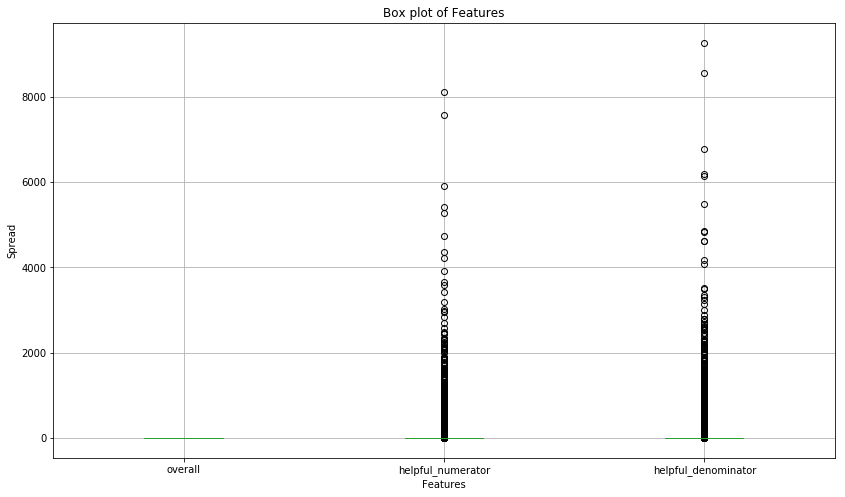

In [16]:
### Box Plot
fig = plt.figure(1,FIG_SIZE)
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xlabel('Features')                

# Create the boxplot
df.boxplot()


As expected this is pretty ugly, let's have a look at a couple of the outliers and make sure they are valid data.

In [17]:
#include reviews that have more than 10 helpfulness data point only
df1 = df[(df.helpful_denominator > 10)].copy()
df1.shape


#transform Helpfulness into a binary variable with 0.50 ratio
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_numerator'] \
                                 / df1.loc[:, 'helpful_denominator'] > threshold, 1, 0)
df1.head(3) 

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
33,3,"I did the 7-day trial and was impressed, but a...",15,20,1
94,5,"This app is great! It has a daily verse, a da...",96,107,1
284,2,This app simply latches on to Google maps and ...,11,23,0


In [18]:
#Check the balance
print ('Count:')
display(df1.groupby('Helpful').count())

helps=df1['Helpful'].loc[df1['Helpful']==1].count()
nothelps=df1['Helpful'].loc[df1['Helpful']==0].count()

Count:


,overall,reviewText,helpful_numerator,helpful_denominator
Helpful,,,,
0,6210,6210,6210,6210
1,41722,41722,41722,41722


In [22]:
import plotly 
plotly.tools.set_credentials_file(username='prabhnoor95kahlon', api_key='TsDEbamEOHVZJMfqD7OD')

In [23]:
trace1 = go.Bar(
    x=['1'],
    y=[helps],
    name='helpful'
)
trace2 = go.Bar(
    x=['2'],
    y=[nothelps],
    name='Not Helpful'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



*We see that the data is imbalanced as number of helpful reviews are 7 times higher than not helpful reviews*

In [24]:
ratings1=df1['overall'].loc[df1['overall']==1].count()
ratings2=df1['overall'].loc[df1['overall']==2].count()
ratings3=df1['overall'].loc[df1['overall']==3].count()
ratings4=df1['overall'].loc[df1['overall']==4].count()
ratings5=df1['overall'].loc[df1['overall']==5].count()
print(ratings1)

12517


In [25]:

labels=['1','2','3','4','5']
values = [ratings1,ratings2,ratings3,ratings4,ratings5]
colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1','tomato']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, 
                         line=dict(color='#000000', width=2)))
layout = go.Layout(
    title='No of Reviews with regard to Ratings'
    
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig,Title='h', filename='styled_pie_chart')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



*We see that most of the reviews are written by those people who either loved the product(rated 5) or hated the product(rated 1)*

In [26]:
overhelpful=df1.loc[df1['Helpful']==1]
rating_1=overhelpful.loc[overhelpful['overall']==1]
rating_2=overhelpful.loc[overhelpful['overall']==2]
rating_3=overhelpful.loc[overhelpful['overall']==3]
rating_4=overhelpful.loc[overhelpful['overall']==4]
rating_5=overhelpful.loc[overhelpful['overall']==5]

rat1=rating_1['Helpful'].count()
rat2=rating_2['Helpful'].count()
rat3=rating_3['Helpful'].count()
rat4=rating_4['Helpful'].count()
rat5=rating_5['Helpful'].count()

In [27]:
import plotly.plotly as pyo
import plotly.graph_objs as go

trace0 = go.Bar(
    x=['1','2','3','4','5'],
    y=[rat1,rat2,rat3,rat4,rat5],
    text=['Rating 1', 'Rating 2', 'Rating 3','Rating 4','Rating 5'],
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
           
        )
    ),
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title='',
    xaxis=dict(
        title='Ratings',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Helpful Reviews',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
))

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig,  yTitle='Helpful Reviews',xTitle='Ratings',filename='text-hover-bar')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



*We wanted to see that can we use the ratings to tell if the review is helpful or not.We see that leaving the reviews that have given rating 1 the helpfulness is proprtional to ratings, as we move from reviews that have given rating 2 to rating 5 the number of helpful reviews increase.*
 
*This could be also because,  overall, the rating 5 and 1 reviews are more.*

*To fully end the speculation that ratings can help to classify if the review is helpful or not we came up with  correlation heatmap in the following cell.*

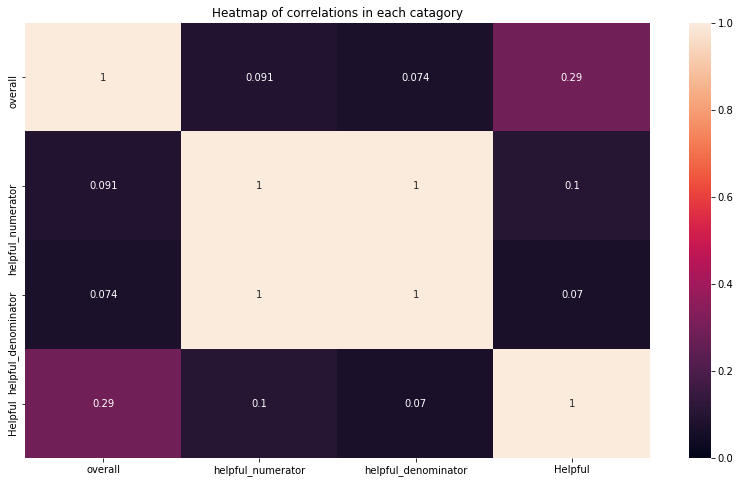

In [28]:
#Visualize correlation of the data
correlations = df1.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

*We can also see that there is a very small correlation between the overall(ratings) and helpful(whether the review is helpful or not).This means we have to use text classification on reviews to predict if the review is helpful or not*

## *Data Cleaning*
- removing Punctuations
- Coverting the data to lower case.
- Remove all the special characters(!@)
- Remove single characters from the start
- Substituting multiple spaces with single space
- Removing numbers(0-9)
- Removing Stop words:This removes words such as "the" "a" and "it" as shown in the English stop words corpus.as these  will     only clutter up our learning algorithm 
- Stemming :It means to take off the suffixes of the stemmed word. Therefore words such as "run" and "running" would both be     represented as "run"

In [29]:
# convert text to lowercase an removed the punctuation marks
df1.loc[:, 'reviewText'] = df1['reviewText'].str.lower()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df1['reviewText']=df1['reviewText'].apply( lambda x: remove_punctuation(x))
df1['reviewText'].head(4)

33     i did the 7day trial and was impressed but am ...
94     this app is great  it has a daily verse a dail...
284    this app simply latches on to google maps and ...
288    unable to move to sd card uninstalled cannot r...
Name: reviewText, dtype: object

In [30]:
ar=[]
stemmer = WordNetLemmatizer()
k=0

for i in df1['reviewText']:
        # Remove all the special characters
    document = re.sub(r'\W', ' ', str(i))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    document=re.sub(r'[0-9]+', '', document)
    document = document.lower()

    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
   
    ar.append(document)    

In [31]:
df1['r']=ar

In [34]:
aj=""
for i in df1['r']:
    aj =aj+i

aj1=""
aj1=aj.strip()
aj1=aj1.split()

ak=[]
for word in aj1:
    if word not in stops:
        ak.append(word)

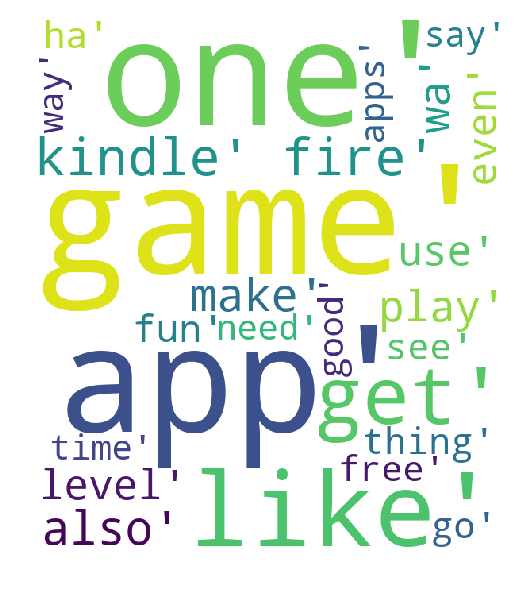

In [51]:
#Creating a word cloud of most frequently used  words(25) in reviews

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='White',stopwords=stopwords, max_words=25, min_font_size=20, width=600,height=700).generate(str(ak))

plt.figure(figsize = (8,8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


*After all the cleaning processes, we see some of the most frequently used words in form of wordcloud and its obvious to see kindle as one of the popular words because kindle is one of the popular apps of amazon*

### Spliting the data into training and testing

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1['r'],df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

## *Feature Engineering*
Feature engineering  is needed  to convert free flowing text into some numeric representations which can then be understood by machine learning algorithms

We have converted our data into two types of feature:
- Count Vector
- TF-IDF


**Count Vector**

Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

**TF-IDF**

TF-IDF is short for Term Frequency Inverse Document frequency. TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

       TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
        

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

        IDF(t) = log_e(Total number of documents / Number of documents with term t in it).
        
<br></br>
For our vectorizer, we will also set the min_df to 0.01. This is a cheap way of getting rid of spelling mistakes.
The TF-IDF has two levels in our analysis and they are as followed:

* Word level
* N-gram Level(here we have taken ngram(2,3) that means taking together two and three words)


In [39]:
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems


In [40]:
#define the vectorizer
# For word level tf-idf
vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), max_features= 500000)
#fit the vectorizers to the data.
vectorizer.fit(df1['r'])
X_train_Tfidf_word = vectorizer.transform(X_train)
X_test_Tfidf_word = vectorizer.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



In [41]:
# create a count vectorizer object 
count_vect = CountVectorizer(tokenizer = tokens, stop_words = 'english', token_pattern=r'\w{1,}', min_df= 0.01)
count_vect.fit(df1['r'])

# transform the training and test data using count vectorizer object
Xtrain_Tfidf_count =  count_vect.transform(X_train)
Xtest_Tfidf_count =  count_vect.transform(X_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



In [55]:
# for ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', token_pattern=r'\w{1,}', 
                                   ngram_range=(2,3), max_features=500000)
tfidf_vect_ngram.fit(df1['r'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



## *Model  Training and Selection*

#### We have used the following models: 

<b> 1. Naive Bayes</b>

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. For example, a fruit may be considered to be an apple if it is red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.Naive Bayes model is easy to build and particularly useful for very large data sets. Along with simplicity, Naive Bayes is known to outperform even highly sophisticated classification methods.

<b> 2. Logistic Regression</b>

Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier.Logistic regression can be updated after is has already been trained, meaning that new reviews can be used to teach the algorithm after it has already been training.Logistic regression is not as fast as the naive bayes methods, but then again, not many algorithms are.

<b> 3. SVM</b>

Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well 
It works really well with clear margin of separation and is effective in high dimensional spaces.But it doesn’t perform well, when we have large data set because the required training time is higher and it  also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping.

<b> 4. Decision Tree</b>

Decision Tree (DT) is a supervised learning method used for classification and regression. It is a tree which helps us by assisting us in decision-making.Decision tree builds classification or regression models in the form of a tree structure. It breaks down a data set into smaller and smaller subsets and simultaneously decision tree is incrementally developed. The final tree is a tree with decision nodes and leaf nodes. A decision node has two or more branches. Leaf node represents a classification or decision. We cannot do more split on leaf nodes.The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data.Over fitting is one of the most practical difficulty for decision tree models. This problem gets solved by setting constraints on model parameters and pruning 

<b> 5. Random Forest</b>

 A Random Forest is a ensembling algorithm that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. It does not implement boosting on the trees, and instead counts a vote of each individual tree in order to produce the final class label.The strength of the Random Forest classifier comes from the formation of it's trees. Because it is formed from "random" subsets of the data, and the final result is compared to other trees that have also been formed "randomly", the algorithm guards well against "overfitting" from noisy data points that may have more influence on a single decision tree algorithm. A lot of trees are necessary to get stable estimates of variable importance and proximity. This can lead to a large amount of space in memory being needed to store the trees. Additionally, the trees need to be re-trained when new data is being introduced, unlike Naive Bayes. Its training complexity is given as O(M √d n log n) where d is the number of features and M is the number of trees.
 
### Creating Model training 

In [63]:

def model_train(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    probs = classifier.predict_proba(feature_vector_valid)
    #ROC Values on y_test and ROC curves
    print(roc_auc_score(y_test, probs[:,1].T))
    plt.title('Receiver Operating Characteristic')
    
    y_pred_proba = classifier.predict_proba(feature_vector_valid)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
   
   
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    #take y_test as label 1 and prediction as label 2
    print(metrics.confusion_matrix(y_test,predictions))  
    print(metrics.classification_report(y_test,predictions))  
    return metrics.accuracy_score(predictions, y_test)   

In [57]:
from sklearn.metrics import roc_auc_score, roc_curve

In [45]:
# fit the training dataset on the classifier
fit = linear_model.LogisticRegression().fit(Xtrain_Tfidf_count, y_train)    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



### Model Accuracy check
We firstly focused on Accuracy of the model that is ((number of correctly predicted values /total number of values)*100) to find which model is best but then realised that as data is imbalanced with helpful labeled values more so even if model predicted all as helpful the accuracy came to 86.71%

SO we shifted to AUC - ROC curve.AUC-ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model. 

The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
  
we see that Logistic Regression-(TF-IDF(Word-level)) has highest auc score ie 0.77


0.7230425912696368


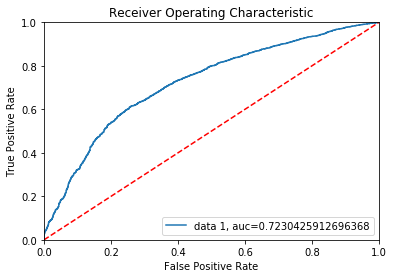

[[ 329  945]
 [ 727 7586]]
              precision    recall  f1-score   support

           0       0.31      0.26      0.28      1274
           1       0.89      0.91      0.90      8313

   micro avg       0.83      0.83      0.83      9587
   macro avg       0.60      0.59      0.59      9587
weighted avg       0.81      0.83      0.82      9587

NB, Count Vectors:  82.55971628246583



0.6746244510073969


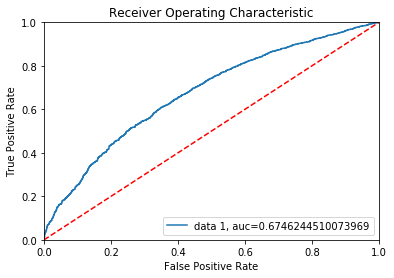

[[   1 1273]
 [   1 8312]]
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      1274
           1       0.87      1.00      0.93      8313

   micro avg       0.87      0.87      0.87      9587
   macro avg       0.68      0.50      0.47      9587
weighted avg       0.82      0.87      0.81      9587

NB, WordLevel TF-IDF:  86.71117137790758



0.6565520497958504


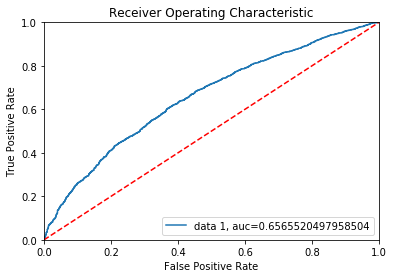

[[   2 1272]
 [   1 8312]]
              precision    recall  f1-score   support

           0       0.67      0.00      0.00      1274
           1       0.87      1.00      0.93      8313

   micro avg       0.87      0.87      0.87      9587
   macro avg       0.77      0.50      0.47      9587
weighted avg       0.84      0.87      0.81      9587

NB, N-Gram Vectors:  86.72160216960467


In [58]:
# Naive Bayes on Count Vectors
accuracy = model_train(naive_bayes.MultinomialNB(), Xtrain_Tfidf_count, y_train, Xtest_Tfidf_count )
print("NB, Count Vectors: ", accuracy*100)

print("")
print("")
print("")

# Naive Bayes on Word Level TF IDF Vectors
accuracy = model_train(naive_bayes.MultinomialNB(),  X_train_Tfidf_word, y_train,X_test_Tfidf_word)
print("NB, WordLevel TF-IDF: ", accuracy*100)

print("")
print("")
print("")

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = model_train(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train,xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy*100)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.7380946715637646


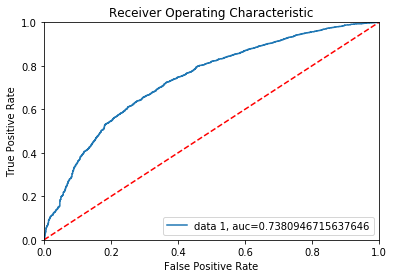

[[  53 1221]
 [  34 8279]]
              precision    recall  f1-score   support

           0       0.61      0.04      0.08      1274
           1       0.87      1.00      0.93      8313

   micro avg       0.87      0.87      0.87      9587
   macro avg       0.74      0.52      0.50      9587
weighted avg       0.84      0.87      0.82      9587

LR, Count Vectors:  86.90935642015229





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.7656049678011837


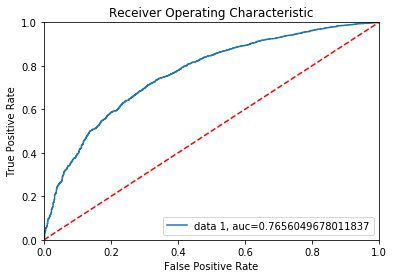

[[  56 1218]
 [  40 8273]]
              precision    recall  f1-score   support

           0       0.58      0.04      0.08      1274
           1       0.87      1.00      0.93      8313

   micro avg       0.87      0.87      0.87      9587
   macro avg       0.73      0.52      0.51      9587
weighted avg       0.83      0.87      0.82      9587

LR, WordLevel TF-IDF:  86.87806404506102





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.7213640529359455


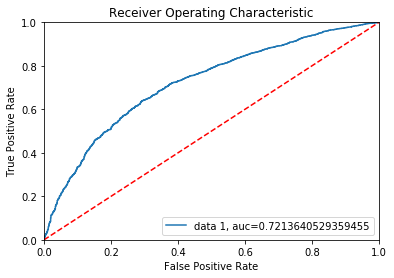

[[   1 1273]
 [   1 8312]]
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      1274
           1       0.87      1.00      0.93      8313

   micro avg       0.87      0.87      0.87      9587
   macro avg       0.68      0.50      0.47      9587
weighted avg       0.82      0.87      0.81      9587

LR, N-Gram Vectors:  86.71117137790758


In [59]:
# Linear Logistic on Count Vectors
accuracy = model_train(linear_model.LogisticRegression(), Xtrain_Tfidf_count, y_train, Xtest_Tfidf_count )
print("LR, Count Vectors: ", accuracy*100)

print("")
print("")
print("")

#Linear Logistic on word Level TF IDF Vectors
accuracy = model_train(linear_model.LogisticRegression(),  X_train_Tfidf_word, y_train,X_test_Tfidf_word)
print("LR, WordLevel TF-IDF: ", accuracy*100)

print("")
print("")
print("")

# Linear Logistic on ngram Level TF IDF Vectors
accuracy = model_train(linear_model.LogisticRegression(), xtrain_tfidf_ngram, y_train,xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy*100)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.6436627978232351


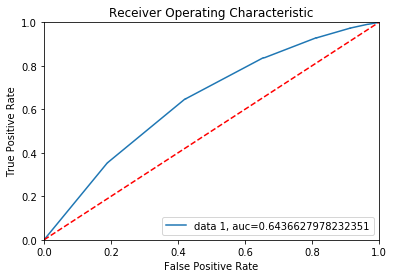

[[ 108 1166]
 [ 217 8096]]
              precision    recall  f1-score   support

           0       0.33      0.08      0.14      1274
           1       0.87      0.97      0.92      8313

   micro avg       0.86      0.86      0.86      9587
   macro avg       0.60      0.53      0.53      9587
weighted avg       0.80      0.86      0.82      9587

RF, Count Vectors:  85.5742150829248





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.6307828936199303


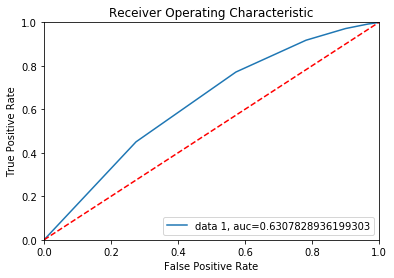

[[  42 1232]
 [  65 8248]]
              precision    recall  f1-score   support

           0       0.39      0.03      0.06      1274
           1       0.87      0.99      0.93      8313

   micro avg       0.86      0.86      0.86      9587
   macro avg       0.63      0.51      0.49      9587
weighted avg       0.81      0.86      0.81      9587

RF, WordLevel TF-IDF:  86.47126316887451





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.6225612000345206


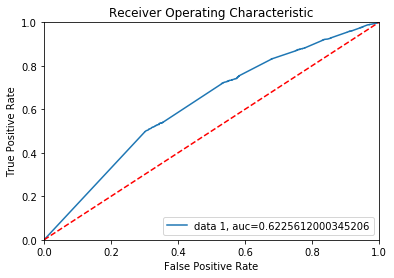

[[ 103 1171]
 [ 323 7990]]
              precision    recall  f1-score   support

           0       0.24      0.08      0.12      1274
           1       0.87      0.96      0.91      8313

   micro avg       0.84      0.84      0.84      9587
   macro avg       0.56      0.52      0.52      9587
weighted avg       0.79      0.84      0.81      9587

RF, N-Gram Vectors:  84.41639720454782


In [49]:
#Random Forest
# RF on Count Vectors
accuracy = model_train(ensemble.RandomForestClassifier(), Xtrain_Tfidf_count, y_train, Xtest_Tfidf_count )
print("RF, Count Vectors: ", accuracy*100)

print("")
print("")
print("")

#RF on word Level TF IDF Vectors
accuracy = model_train(ensemble.RandomForestClassifier(),  X_train_Tfidf_word, y_train,X_test_Tfidf_word)
print("RF, WordLevel TF-IDF: ", accuracy*100)

print("")
print("")
print("")

#RF on ngram Level TF IDF Vectors
accuracy = model_train(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, y_train,xvalid_tfidf_ngram)
print("RF, N-Gram Vectors: ", accuracy*100)


0.5457333948208826


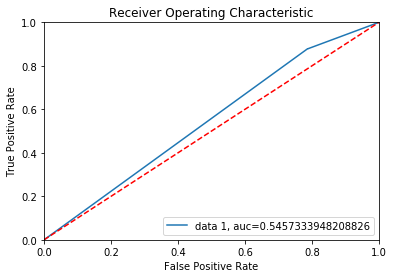

[[ 269 1005]
 [1006 7307]]
              precision    recall  f1-score   support

           0       0.21      0.21      0.21      1274
           1       0.88      0.88      0.88      8313

   micro avg       0.79      0.79      0.79      9587
   macro avg       0.55      0.55      0.55      9587
weighted avg       0.79      0.79      0.79      9587

DT, Count Vectors:  79.0236778971524



0.546179302301383


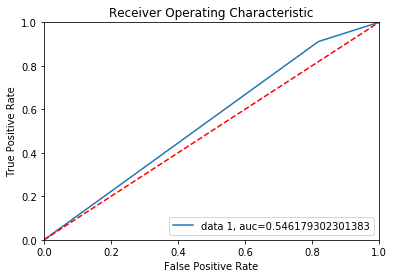

[[ 230 1044]
 [ 733 7580]]
              precision    recall  f1-score   support

           0       0.24      0.18      0.21      1274
           1       0.88      0.91      0.90      8313

   micro avg       0.81      0.81      0.81      9587
   macro avg       0.56      0.55      0.55      9587
weighted avg       0.79      0.81      0.80      9587

DT, WordLevel TF-IDF:  81.4644831542714



0.5523141772046242


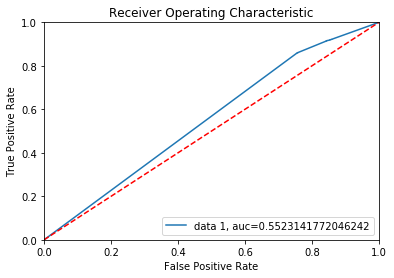

[[ 187 1087]
 [ 671 7642]]
              precision    recall  f1-score   support

           0       0.22      0.15      0.18      1274
           1       0.88      0.92      0.90      8313

   micro avg       0.82      0.82      0.82      9587
   macro avg       0.55      0.53      0.54      9587
weighted avg       0.79      0.82      0.80      9587

DT, N-Gram Vectors:  81.66266819651612


In [55]:
# Decision Tree on Count Vectors
accuracy = model_train(tree.DecisionTreeClassifier(), Xtrain_Tfidf_count, y_train, Xtest_Tfidf_count )
print("DT, Count Vectors: ", accuracy*100)

print("")
print("")
print("")

# Decision Tree on word Level TF IDF Vectors
accuracy = model_train(tree.DecisionTreeClassifier(),  X_train_Tfidf_word, y_train,X_test_Tfidf_word)
print("DT, WordLevel TF-IDF: ", accuracy*100)

print("")
print("")
print("")

# Decision Tree on ngram Level TF IDF Vectors
accuracy = model_train(tree.DecisionTreeClassifier(), xtrain_tfidf_ngram, y_train,xvalid_tfidf_ngram)
print("DT, N-Gram Vectors: ", accuracy*100)


In [60]:
# SVM on ngram Level TF IDF Vectors   # fit the training dataset on the classifier
classifier=svm.SVC()
classifier.fit(xtrain_tfidf_ngram,y_train)

predictions = classifier.predict(xvalid_tfidf_ngram)

print(metrics.confusion_matrix(y_test,predictions))  
print(metrics.classification_report(y_test,predictions))  
accuracy=metrics.accuracy_score(predictions, y_test)
    
    

print("SVM, N-Gram Vectors: ", accuracy*100)    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



[[   0 1274]
 [   0 8313]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1274
           1       0.87      1.00      0.93      8313

   micro avg       0.87      0.87      0.87      9587
   macro avg       0.43      0.50      0.46      9587
weighted avg       0.75      0.87      0.81      9587

SVM, N-Gram Vectors:  86.71117137790758


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



# Conclusion

#### *Amazon Point of View* 

- This would help amazon put new reviews on the top if they are helpful which would enhance customer experience

#### *Text Classification*

- Tried to find a link between ratings and helpful reviews, but since the correlation was low, we realized that Text             classification would be needed to classify reviews as helpful or not.

- Gathered a better understanding of the classic problem in NLP, text classification, and learned about important concepts like     feature engineering(TF-IDF Vector, Count Vectors).

- Understood that accuracy is not a good measure when data is imbalanced and utilized AUC-ROC Curve as a performance measure to   select models 

- Selected Logistic regression (TF-IDF-Word Level) since it had the highest AUC score.



# References

1.   https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
2.  https://medium.com/machine-learning-intuition/document-classification-part-2-text-processing-eaa26d16c719
3.  https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
4.  https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3
5.  https://stackabuse.com/text-classification-with-python-and-scikit-learn/
6.  http://maxmelnick.com/2016/06/07/amazon-review-helpfulness-classification.html
